In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms

import time
import os
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic= True
torch.backends.cudnn.benchmark= False
cudnn.benchmark = True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
data_dir = '/content/drive/MyDrive/data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True)
              for x in ['train', 'val']}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def imshow(inp, title=None):

    inp = inp.numpy().transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)


    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)

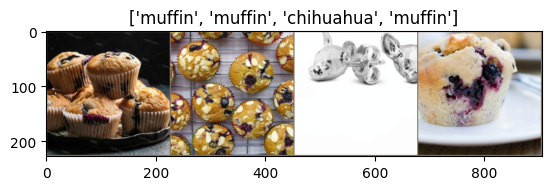

In [ ]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

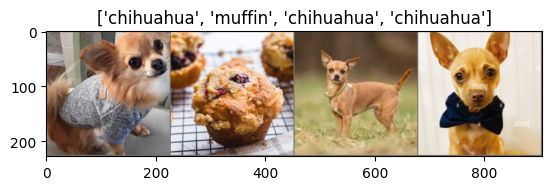

In [ ]:
inputs, classes = next(iter(dataloaders['val']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):


    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)


                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                     # convert logits to predictions using sigmoid
                    preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert to 0 or 1

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


            if phase == 'val' and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_accuracy:4f}')

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=8):

    was_training = model.training
    model.eval()
    images_displayed = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_displayed += 1
                ax = plt.subplot(num_images//2, 2, images_displayed)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_displayed == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
# load the resnet model
model_ft = models.resnet18(weights=True)

# obtain the number of input features for our final layer
num_ftrs = model_ft.fc.in_features

## change to output 2 logits
model_ft.fc = nn.Linear(num_ftrs, 1)

# move the model to the device
model_ft = model_ft.to(device)

## change the loss function to BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()

# optimize all parameters of the model
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# decay learning rate (lr) by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.3191 Acc: 0.8671
val Loss: 0.0391 Acc: 0.9907

Epoch 1/9
----------
train Loss: 0.2472 Acc: 0.9026
val Loss: 0.0229 Acc: 0.9949

Epoch 2/9
----------
train Loss: 0.1938 Acc: 0.9233
val Loss: 0.0259 Acc: 0.9932

Epoch 3/9
----------
train Loss: 0.1407 Acc: 0.9487
val Loss: 0.0138 Acc: 0.9958

Epoch 4/9
----------
train Loss: 0.1075 Acc: 0.9590
val Loss: 0.0166 Acc: 0.9958

Epoch 5/9
----------
train Loss: 0.0912 Acc: 0.9637
val Loss: 0.0196 Acc: 0.9941

Epoch 6/9
----------
train Loss: 0.0943 Acc: 0.9664
val Loss: 0.0267 Acc: 0.9907

Epoch 7/9
----------
train Loss: 0.0575 Acc: 0.9784
val Loss: 0.0149 Acc: 0.9958

Epoch 8/9
----------
train Loss: 0.0583 Acc: 0.9784
val Loss: 0.0152 Acc: 0.9958

Epoch 9/9
----------
train Loss: 0.0463 Acc: 0.9844
val Loss: 0.0139 Acc: 0.9958

Training complete in 66m 49s
Best val Acc: 0.995777
